THIS IS THE OFFICIAL CODE FILE.


In [ ]:
pip install simpy

In [ ]:
pip install matplotlib

In [ ]:
import random
import simpy
import matplotlib.pyplot as plt

# simComponent

In [ ]:
"""
    A bit more detailed set of components to use in packet switching
    queueing experiments.
    Copyright 2014 Greg M. Bernstein
    Released under the MIT license
"""
import simpy
import random
import copy
from simpy.core import BoundClass
from simpy.resources import base
from heapq import heappush, heappop


class Packet(object):
    """ A very simple class that represents a packet.
        This packet will run through a queue at a switch output port.
        We use a float to represent the size of the packet in bytes so that
        we can compare to ideal M/M/1 queues.

        Parameters
        ----------
        time : float
            the time the packet arrives at the output queue.
        size : float
            the size of the packet in bytes
        id : int
            an identifier for the packet
        src, dst : int
            identifiers for source and destination
        flow_id : int
            small integer that can be used to identify a flow
    """
    def __init__(self, time, size, id, src="a", dst="z", flow_id=0):
        self.time = time
        self.size = size
        self.id = id
        self.src = src
        self.dst = dst
        self.flow_id = flow_id

    def __repr__(self):
        return "id: {}, src: {}, time: {}, size: {}".\
            format(self.id, self.src, self.time, self.size)


class PacketGenerator(object):
    """ Generates packets with given inter-arrival time distribution.
        Set the "out" member variable to the entity to receive the packet.

        Parameters
        ----------
        env : simpy.Environment
            the simulation environment
        adist : function
            a no parameter function that returns the successive inter-arrival times of the packets
        sdist : function
            a no parameter function that returns the successive sizes of the packets
        initial_delay : number
            Starts generation after an initial delay. Default = 0
        finish : number
            Stops generation at the finish time. Default is infinite


    """
    def __init__(self, env, id,  adist, sdist, initial_delay=0, finish=float("inf"), flow_id=0):
        self.id = id
        self.env = env
        self.adist = adist
        self.sdist = sdist
        self.initial_delay = initial_delay
        self.finish = finish
        self.out = None
        self.packets_sent = 0
        self.action = env.process(self.run())  # starts the run() method as a SimPy process
        self.flow_id = flow_id

    def run(self):
        """The generator function used in simulations.
        """
        yield self.env.timeout(self.initial_delay)
        while self.env.now < self.finish:
            # wait for next transmission
            yield self.env.timeout(self.adist())
            self.packets_sent += 1
            p = Packet(self.env.now, self.sdist(), self.packets_sent, src=self.id, flow_id=self.flow_id)
            self.out.put(p)


class PacketSink(object):
    """ Receives packets and collects delay information into the
        waits list. You can then use this list to look at delay statistics.

        Parameters
        ----------
        env : simpy.Environment
            the simulation environment
        debug : boolean
            if true then the contents of each packet will be printed as it is received.
        rec_arrivals : boolean
            if true then arrivals will be recorded
        absolute_arrivals : boolean
            if true absolute arrival times will be recorded, otherwise the time between consecutive arrivals
            is recorded.
        rec_waits : boolean
            if true waiting time experienced by each packet is recorded
        selector: a function that takes a packet and returns a boolean
            used for selective statistics. Default none.

    """
    def __init__(self, env, rec_arrivals=False, absolute_arrivals=False, rec_waits=True, debug=False, selector=None):
        self.store = simpy.Store(env)
        self.env = env
        self.rec_waits = rec_waits
        self.rec_arrivals = rec_arrivals
        self.absolute_arrivals = absolute_arrivals
        self.waits = []
        self.arrivals = []
        self.debug = debug
        self.packets_rec = 0
        self.bytes_rec = 0
        self.selector = selector
        self.last_arrival = 0.0

    def put(self, pkt):
        if not self.selector or self.selector(pkt):
            now = self.env.now
            if self.rec_waits:
                self.waits.append(self.env.now - pkt.time)
            if self.rec_arrivals:
                if self.absolute_arrivals:
                    self.arrivals.append(now)
                else:
                    self.arrivals.append(now - self.last_arrival)
                self.last_arrival = now
            self.packets_rec += 1
            self.bytes_rec += pkt.size
            if self.debug:
                print(pkt)


class SwitchPort(object):
    """ Models a switch output port with a given rate and buffer size limit in bytes.
        Set the "out" member variable to the entity to receive the packet.

        Parameters
        ----------
        env : simpy.Environment
            the simulation environment
        rate : float
            the bit rate of the port
        qlimit : integer (or None)
            a buffer size limit in bytes or packets for the queue (including items
            in service).
        limit_bytes : If true, the queue limit will be based on bytes if false the
            queue limit will be based on packets.

    """
    def __init__(self, env, rate, qlimit=None, limit_bytes=True, debug=False):
        self.store = simpy.Store(env)
        self.rate = rate
        self.env = env
        self.out = None
        self.packets_rec = 0
        self.packets_drop = 0
        self.qlimit = qlimit
        self.limit_bytes = limit_bytes
        self.byte_size = 0  # Current size of the queue in bytes
        self.debug = debug
        self.busy = 0  # Used to track if a packet is currently being sent
        self.action = env.process(self.run())  # starts the run() method as a SimPy process

    def run(self):
        while True:
            msg = (yield self.store.get())
            self.busy = 1
            self.byte_size -= msg.size
            yield self.env.timeout(msg.size*8.0/self.rate)
            self.out.put(msg)
            self.busy = 0
            if self.debug:
                print(msg)

    def put(self, pkt):
        self.packets_rec += 1
        tmp_byte_count = self.byte_size + pkt.size

        if self.qlimit is None:
            self.byte_size = tmp_byte_count
            return self.store.put(pkt)
        if self.limit_bytes and tmp_byte_count >= self.qlimit:
            self.packets_drop += 1
            return
        elif not self.limit_bytes and len(self.store.items) >= self.qlimit-1:
            self.packets_drop += 1
        else:
            self.byte_size = tmp_byte_count
            return self.store.put(pkt)


class PortMonitor(object):
    """ A monitor for an SwitchPort. Looks at the number of items in the SwitchPort
        in service + in the queue and records that info in the sizes[] list. The
        monitor looks at the port at time intervals given by the distribution dist.

        Parameters
        ----------
        env : simpy.Environment
            the simulation environment
        port : SwitchPort
            the switch port object to be monitored.
        dist : function
            a no parameter function that returns the successive inter-arrival times of the
            packets
    """
    def __init__(self, env, port, dist, count_bytes=False):
        self.port = port
        self.env = env
        self.dist = dist
        self.count_bytes = count_bytes
        self.sizes = []
        self.action = env.process(self.run())

    def run(self):
        while True:
            yield self.env.timeout(self.dist())
            if self.count_bytes:
                total = self.port.byte_size
            else:
                total = len(self.port.store.items) + self.port.busy
            self.sizes.append(total)


class RandomBrancher(object):
    """ A demultiplexing element that chooses the output port at random.

        Contains a list of output ports of the same length as the probability list
        in the constructor.  Use these to connect to other network elements.

        Parameters
        ----------
        env : simpy.Environment
            the simulation environment
        probs : List
            list of probabilities for the corresponding output ports
    """
    def __init__(self, env, probs):
        self.env = env

        self.probs = probs
        self.ranges = [sum(probs[0:n+1]) for n in range(len(probs))]  # Partial sums of probs
        if self.ranges[-1] - 1.0 > 1.0e-6:
            raise Exception("Probabilities must sum to 1.0")
        self.n_ports = len(self.probs)
        self.outs = [None for i in range(self.n_ports)]  # Create and initialize output ports
        self.packets_rec = 0

    def put(self, pkt):
        self.packets_rec += 1
        rand = random.random()
        for i in range(self.n_ports):
            if rand < self.ranges[i]:
                if self.outs[i]:  # A check to make sure the output has been assigned before we put to it
                    self.outs[i].put(pkt)
                return


class FlowDemux(object):
        """ A demultiplexing element that splits packet streams by flow_id.

        Contains a list of output ports of the same length as the probability list
        in the constructor.  Use these to connect to other network elements.

        Parameters
        ----------
        outs : List
            list of probabilities for the corresponding output ports
    """
        def __init__(self, outs=None, default=None):
            self.outs = outs
            self.default = default
            self.packets_rec = 0

        def put(self, pkt):
            self.packets_rec += 1
            flow_id = pkt.flow_id
            if flow_id < len(self.outs):
                self.outs[flow_id].put(pkt)
            else:
                if self.default:
                    self.default.put(pkt)

class TrTCM(object):
    """ A Two rate three color marker. Uses the flow_id packet field to
        mark the packet with green = 0, yellow = 1, red = 2.

        Parameters
        ----------
        env : the SimPy environment (so we can get the simulated time)
        pir : Peak Information Rate in units of bits (slighly different from RFC)
        pbs : Peak Burst Size in units of bytes
        cir : Committed Information Rate in units of bits (time part maybe scaled)
        cbs : Committed Burst Size in bytes
    """
    def __init__(self, env, pir, pbs, cir, cbs):
        self.env = env
        self.out = None
        self.pir = pir
        self.pbs = pbs
        self.cir = cir
        self.cbs = cbs
        self.pbucket = pbs
        self.cbucket = cbs
        self.last_time = 0.0  # Last time we updated buckets

    def put(self, pkt):
        time_inc = self.env.now - self.last_time
        self.last_time = self.env.now
        # Add bytes to the buckets
        self.pbucket += self.pir*time_inc/8.0  # rate in bits, bucket in bytes
        if self.pbucket > self.pbs:
            self.pbucket = self.pbs
        self.cbucket += self.cir*time_inc/8.0  # rate in bits, bucket in bytes
        if self.cbucket > self.cbs:
            self.cbucket = self.cbs
        # Check marking criteria and mark
        if self.pbucket - pkt.size < 0:
            pkt.flow_id = 2  # Red packet
        elif self.cbucket - pkt.size < 0:
            pkt.flow_id = 1  # Yellow packet
            self.pbucket -= pkt.size
        else:
            pkt.flow_id = 0  # Green packet
            self.pbucket -= pkt.size
            self.cbucket -= pkt.size
        # Send marked packet on its way
        self.out.put(pkt)

class SnoopSplitter(object):
    """ A snoop port like splitter. Sends the original packet out port 1
        and sends a copy of the packet out port 2.

        You need to set the values of out1 and out2.
    """
    def __init__(self):
        self.out1 = None
        self.out2 = None

    def put(self, pkt):
        pkt2 = copy.copy(pkt)
        if self.out1:
            self.out1.put(pkt)
        if self.out2:
            self.out2.put(pkt2)

"""
    Trying to implement a stamped/ordered version of the Simpy Store class.
    The "stamp" is used to sort the elements for removal ordering. This
    can be used in the implementation of sophisticated queueing disciplines, but
    would be overkill for fixed priority schemes.

    Copyright 2014 Greg M. Bernstein
    Released under the MIT license
"""


class StampedStorePut(base.Put):
    """ Put *item* into the store if possible or wait until it is.
        The item must be a tuple (stamp, contents) where the stamp is used to sort
        the content in the StampedStore.
    """
    def __init__(self, resource, item):
        self.item = item
        """The item to put into the store."""
        super(StampedStorePut, self).__init__(resource)


class StampedStoreGet(base.Get):
    """Get an item from the store or wait until one is available."""
    pass


class StampedStore(base.BaseResource):
    """Models the production and consumption of concrete Python objects.

    Items put into the store can be of any type.  By default, they are put and
    retrieved from the store in a first-in first-out order.

    The *env* parameter is the :class:`~simpy.core.Environment` instance the
    container is bound to.

    The *capacity* defines the size of the Store and must be a positive number
    (> 0). By default, a Store is of unlimited size. A :exc:`ValueError` is
    raised if the value is negative.

    """
    def __init__(self, env, capacity=float('inf')):
        super(StampedStore, self).__init__(env, capacity=float('inf'))
        if capacity <= 0:
            raise ValueError('"capacity" must be > 0.')
        self._capacity = capacity
        self.items = []  # we are keeping items sorted by stamp
        self.event_count = 0 # Used to break ties with python heap implementation
        # See: https://docs.python.org/3/library/heapq.html?highlight=heappush#priority-queue-implementation-notes
        """List of the items within the store."""

    @property
    def capacity(self):
        """The maximum capacity of the store."""
        return self._capacity

    put = BoundClass(StampedStorePut)
    """Create a new :class:`StorePut` event."""

    get = BoundClass(StampedStoreGet)
    """Create a new :class:`StoreGet` event."""

    # We assume the item is a tuple: (stamp, packet). The stamp is used to
    # sort the packet in the heap.
    def _do_put(self, event):
        self.event_count += 1 # Needed this to break heap ties
        if len(self.items) < self._capacity:
            heappush(self.items, [event.item[0], self.event_count, event.item[1]])
            event.succeed()

    # When we return an item from the stamped store we do not
    # return the stamp but only the content portion.
    def _do_get(self, event):
        if self.items:
            event.succeed(heappop(self.items)[2])

"""
    A Set of components to enable simulation of various networking QoS scenarios.

    Copyright 2014 Dr. Greg Bernstein
    Released under the MIT license
"""


class ShaperTokenBucket(object):
    """ Models an ideal token bucket shaper. Note the token bucket size should be greater than the
        size of the largest packet that can occur on input. If this is not the case we always accumulate
        enough tokens to let the current packet pass based on the average rate. This may not be
        the behavior you desire.

        Parameters
        ----------
        env : simpy.Environment
            the simulation environment
        rate : float
            the token arrival rate in bits
        b_size : Number
            a token bucket size in bytes
        peak : Number or None for infinite peak
            the peak sending rate of the buffer (quickest time two packets could be sent)

    """
    def __init__(self, env, rate, b_size, peak=None, debug=False):
        self.store = simpy.Store(env)
        self.rate = rate
        self.env = env
        self.out = None
        self.packets_rec = 0
        self.packets_sent = 0
        self.b_size = b_size
        self.peak = peak

        self.current_bucket = b_size  # Current size of the bucket in bytes
        self.update_time = 0.0  # Last time the bucket was updated
        self.debug = debug
        self.busy = 0  # Used to track if a packet is currently being sent ?
        self.action = env.process(self.run())  # starts the run() method as a SimPy process

    def run(self):
        while True:
            msg = (yield self.store.get())
            now = self.env.now
            #  Add tokens to bucket based on current time
            self.current_bucket = min(self.b_size, self.current_bucket + self.rate*(now-self.update_time)/8.0)
            self.update_time = now
            #  Check if there are enough tokens to allow packet to be sent
            #  If not we will wait to accumulate enough tokens to let this packet pass
            #  regardless of the bucket size.
            if msg.size > self.current_bucket:  # Need to wait for bucket to fill before sending
                yield self.env.timeout((msg.size - self.current_bucket)*8.0/self.rate)
                self.current_bucket = 0.0
                self.update_time = self.env.now
            else:
                self.current_bucket -= msg.size
                self.update_time = self.env.now
            # Send packet
            if not self.peak:  # Infinite peak rate
                self.out.put(msg)
            else:
                yield self.env.timeout(msg.size*8.0/self.peak)
                self.out.put(msg)
            self.packets_sent += 1
            if self.debug:
                print(msg)

    def put(self, pkt):
        self.packets_rec += 1
        return self.store.put(pkt)


class VirtualClockServer(object):
    """ Models a virtual clock server. For theory and implementation see:
        L. Zhang, Virtual clock: A new traffic control algorithm for packet switching networks,
        in ACM SIGCOMM Computer Communication Review, 1990, vol. 20, pp. 19.


        Parameters
        ----------
        env : simpy.Environment
            the simulation environment
        rate : float
            the bit rate of the port
        vticks : A list
            list of the vtick parameters (for each possible packet flow_id). We assume a simple assignment of
            flow id to vticks, i.e., flow_id = 0 corresponds to vticks[0], etc... We assume that the vticks are
            the inverse of the desired rates for the flows in bits per second.
    """
    def __init__(self, env, rate, vticks, debug=False):
        self.env = env
        self.rate = rate
        self.vticks = vticks
        self.auxVCs = [0.0 for i in range(len(vticks))]  # Initialize all the auxVC variables
        self.out = None
        self.packets_rec = 0
        self.packets_drop = 0
        self.debug = debug
        self.store = StampedStore(env)
        self.action = env.process(self.run())  # starts the run() method as a SimPy process

    def run(self):
        while True:
            msg = (yield self.store.get())
            # Send message
            yield self.env.timeout(msg.size*8.0/self.rate)
            self.out.put(msg)

    def put(self, pkt):
        self.packets_rec += 1
        now = self.env.now
        flow_id = pkt.flow_id
        # Update of auxVC for the flow. We assume that vticks is the desired bit time
        # i.e., the inverse of the desired bits per second data rate.
        # Hence we then multiply this value by the size of the packet in bits.
        self.auxVCs[flow_id] = max(now, self.auxVCs[flow_id]) + self.vticks[flow_id]*pkt.size*8.0
        # Lots of work to do here to implement the queueing discipline
        return self.store.put((self.auxVCs[flow_id], pkt))


class WFQServer(object):
    """ Models a WFQ/PGPS server. For theory and implementation see:



        Parameters
        ----------
        env : simpy.Environment
            the simulation environment
        rate : float
            the bit rate of the port
        phis : A list
            list of the phis parameters (for each possible packet flow_id). We assume a simple assignment of
            flow id to phis, i.e., flow_id = 0 corresponds to phis[0], etc...
    """
    def __init__(self, env, rate, phis, debug=False):
        self.env = env
        self.rate = rate
        self.phis = phis
        self.F_times = [0.0 for i in range(len(phis))]  # Initialize all the finish time variables
        # We keep track of the number of packets from each flow in the queue
        self.flow_queue_count = [0 for i in range(len(phis))]
        self.active_set = set()
        self.vtime = 0.0
        self.out = None
        self.packets_rec = 0
        self.packets_drop = 0
        self.debug = debug
        self.store = StampedStore(env)
        self.action = env.process(self.run())  # starts the run() method as a SimPy process
        self.last_update = 0.0

    def run(self):
        while True:
            msg = (yield self.store.get())
            self.last_update = self.env.now
            flow_id = msg.flow_id
            # update information about flow items in queue
            self.flow_queue_count[flow_id] -= 1
            if self.flow_queue_count[flow_id] == 0:
                self.active_set.remove(flow_id)
            # If end of busy period, reset virtual time and reinitialize finish times.
            if len(self.active_set) == 0:
                self.vtime = 0.0
                for i in range(len(self.F_times)):
                    self.F_times[i] = 0.0
            # Send message
            yield self.env.timeout(msg.size*8.0/self.rate)
            self.out.put(msg)

    def put(self, pkt):
        self.packets_rec += 1
        now = self.env.now
        flow_id = pkt.flow_id
        self.flow_queue_count[flow_id] += 1
        self.active_set.add(flow_id)
        phi_sum = 0.0
        for i in self.active_set:
            phi_sum += self.phis[i]
        self.vtime += (now-self.last_update)/phi_sum
        self.F_times[flow_id] = max(self.F_times[flow_id], self.vtime) + pkt.size*8.0/self.phis[flow_id]
        # print "Flow id = {}, packet_id = {}, F_time = {}".format(flow_id, pkt.id, self.F_times[flow_id])
        self.last_update = now
        return self.store.put((self.F_times[flow_id], pkt))

# Parameters


In [ ]:
mean_pkt_size = 100.0
mean_arrival_time = 2.0     #change this value
mean_service_rate1 = 4*8*mean_pkt_size
mean_service_rate2 = 2*8*mean_pkt_size
mean_service_rate3 = 3*8*mean_pkt_size

In [ ]:
def pkt_size():
    return random.expovariate(1.0 / mean_pkt_size)

def arrival_time():
    return random.expovariate(1.0 / mean_arrival_time)

def calservice_rate1():
    return random.expovariate(1.0 / (mean_service_rate1))

def calservice_rate2():
    return random.expovariate(1.0 / (mean_service_rate2))

def calservice_rate3():
    return random.expovariate(1.0 / (mean_service_rate3)) 

def monitor_rate():
    return 1

# System

In [ ]:
def system_run():
    env = simpy.Environment()

    #ps0 = PacketSink(env, debug=False, rec_arrivals=True, rec_waits=True)
    ps1 = PacketSink(env, debug=False, rec_arrivals=True, rec_waits=True)
    ps2 = PacketSink(env, debug=False, rec_arrivals=True, rec_waits=True)
    pg = PacketGenerator(env, "src", arrival_time, pkt_size)
    service_rate1 = calservice_rate1()
    service_rate2 = calservice_rate2()
    service_rate3 = calservice_rate3()
    switch_port1 = SwitchPort(env, service_rate1)
    switch_port2 = SwitchPort(env, service_rate2)
    switch_port3 = SwitchPort(env, service_rate3)
    branch = RandomBrancher(env, [0.7, 0.3])

    pg.out = switch_port1
    switch_port1.out = branch
    branch.outs[0] = switch_port2
    branch.outs[1] = switch_port3
    #switch_port2.out = ps0
    #switch_port3.out = ps0
    switch_port2.out = ps1
    switch_port3.out = ps2

    pm1 = PortMonitor(env, switch_port1, monitor_rate)
    pm2 = PortMonitor(env, switch_port2, monitor_rate)
    pm3 = PortMonitor(env, switch_port3, monitor_rate)

    env.run(until=100)

    #return [ps0, pm1, pm2, pm3]
    return [ps1, ps2, pm1, pm2, pm3]

# Intial Data Deletion

In [ ]:
def deleteInitialData(matrix, m, n):
    #step 1
    xj_h = []
    for j in range(n):
        s = 0.0
        for i in range(m):
            s = s + matrix[i][j]
        xj_h.append(s / m)
    
    #step 2
    x_hh = sum(xj_h) / n

    #step 3
    xl_hh = []
    relative_change = []
    for l in range(0, n):
        s = 0.0
        for i in range(l, n):
            s = s + xj_h[i]
        xl_hh.append(s / (n - l))
        relative_change.append((xl_hh[l - 1] - x_hh) / x_hh)

    return [xl_hh, relative_change]

In [ ]:
def variance(l):
    n = len(l)
    mean = sum(l) / n
    deviations = [(x - mean) ** 2 for x in l]
    var = sum(deviations) / n
    return var

# Data plot

In [ ]:
def plot(x, y, mode = ""):
    font = {'family': 'monospace',
        'color':  'black',
        'weight': 'normal',
        'size': 12,
        }

    if (mode == "total_occupacy"):
        fig, g = plt.subplots(2, constrained_layout=True)
        fig.suptitle('Average occupacy in the system at the specific time from 0 -> 100s; mean arrival time = 2s', fontdict=font)

        g[0].set_title('Average occupacy in the system', fontdict=font)
        g[0].set_xlabel('time (s)', fontdict=font)
        g[0].set_ylabel('number of packets', fontdict=font)
        g[0].bar(x, y[0], width = 0.5)
        g[0].grid()

        g[1].set_title('Relative change', fontdict=font)
        g[1].set_xlabel('time (s)', fontdict=font)
        g[1].plot(x, y[1])
        g[1].grid()

    elif (mode == "occupacy"):
        fig, g = plt.subplots(2, constrained_layout=True)
        fig.suptitle('Average occupacy at SwitchPort 1, 2, 3 at the specific time from 0 -> 100s; mean arrival time = 2s', fontdict=font)
        x_1 = []
        x_3 = []
        for i in x:
            x_1.append(i - 0.3)
            x_3.append(i + 0.3)

        g[0].set_title('Average occupacy in 2 SwitchPorts', fontdict=font)
        g[0].set_xlabel('time (s)', fontdict=font)
        g[0].set_ylabel('number of packets', fontdict=font)
        g[0].bar(x_1, y[0], width = 0.3, color = 'green', label='SwitchPort 1')
        g[0].bar(x, y[1], width = 0.3, label='SwitchPort 2')
        g[0].bar(x_3, y[2], width = 0.3, color='red', label='SwitchPort 3')
        g[0].legend()
        g[0].grid()

        g[1].set_title('Relative change', fontdict=font)
        g[1].set_xlabel('time (s)', fontdict=font)
        g[1].plot(x, y[3], color = 'green', label='SwitchPort 1')
        g[1].plot(x, y[4], label='SwitchPort 2')
        g[1].plot(x, y[5], color = 'red', label='SwitchPort 3')
        g[1].legend()
        g[1].grid()

    elif(mode == "total_waiting_time"):
        fig, g = plt.subplots(2, constrained_layout=True)
        fig.suptitle('Average waiting time of 1 packet in the system, mean arrival time = 0.1s', fontdict=font)

        g[0].set_title('Average waiting time in the system', fontdict=font)
        g[0].set_xlabel('packet (th)', fontdict=font)
        g[0].set_ylabel('time (s)', fontdict=font)
        g[0].bar(x, y[0], width = 0.5)
        g[0].grid()

        g[1].set_title('Relative change', fontdict=font)
        g[1].set_xlabel('packet (th)', fontdict=font)
        g[1].plot(x, y[1])
        g[1].grid()

    plt.show()

# main

In [ ]:
def processTotalWaitingTime(m_replication):
    average_total_waiting_time_list = []
    n_total_waiting_time = 50
    n_total_waiting_time_list = list(range(n_total_waiting_time))
  
    i = 0
    while (i != m_replication):
        ps = system_run()
        if (len(ps[0].waits) == 50):
            average_total_waiting_time_list.append(ps[0].waits)
            i = i + 1
    
    processed_total_waiting_time = deleteInitialData(average_total_waiting_time_list, m_replication, n_total_waiting_time)

    plot(n_total_waiting_time_list, processed_total_waiting_time, "total_waiting_time")
    print("Variance of average waiting time in the system: " + str(variance(processed_total_waiting_time[0])))
    print("Variance of relative change: " + str(variance(processed_total_waiting_time[1])))

In [ ]:
def processTotalOccupacy(m_replication):
    total_occupacy = []
    n_total_occupacy = 99
    n_total_occupacy_list = list(range(n_total_occupacy))

    for i in range(m_replication):
        ps = system_run()
        s_total_occupacy = []
        for j in range(len(ps[1].sizes)):
            s_total_occupacy.append(ps[1].sizes[j] + ps[2].sizes[j] + ps[3].sizes[j])
        total_occupacy.append(s_total_occupacy)

    processed_total_occupacy = deleteInitialData(total_occupacy, m_replication, n_total_occupacy)

    plot(n_total_occupacy_list, processed_total_occupacy, "total_occupacy")
    print("Variance of average total occupacy: " + str(variance(processed_total_occupacy[0])))
    print("Variance of relative change: " + str(variance(processed_total_occupacy[1])))

In [ ]:
def processOccupacy(m_replication):
    occupacy_1 = []
    occupacy_2 = []
    occupacy_3 = []
    n_occupacy = 99
    n_occupacy_list = list(range(n_occupacy))

    for i in range(m_replication):
        ps = system_run()
        occupacy_1.append(ps[2].sizes)
        occupacy_2.append(ps[3].sizes)
        occupacy_3.append(ps[4].sizes)

    processed_occupacy_1 = deleteInitialData(occupacy_1, m_replication, n_occupacy)
    processed_occupacy_2 = deleteInitialData(occupacy_2, m_replication, n_occupacy)
    processed_occupacy_3 = deleteInitialData(occupacy_3, m_replication, n_occupacy)

    processed_occupacy = []
    processed_occupacy.append(processed_occupacy_1[0])
    processed_occupacy.append(processed_occupacy_2[0])
    processed_occupacy.append(processed_occupacy_3[0])
    processed_occupacy.append(processed_occupacy_1[1])
    processed_occupacy.append(processed_occupacy_2[1])
    processed_occupacy.append(processed_occupacy_3[1])
    plot(n_occupacy_list, processed_occupacy, "occupacy")
    print("Variance of average occupacy in SwitchPort 1: " + str(variance(processed_occupacy[0])))
    print("Variance of average occupacy in SwitchPort 2: " + str(variance(processed_occupacy[1])))
    print("Variance of average occupacy in SwitchPort 3: " + str(variance(processed_occupacy[2])))
    print("Variance of relative change of SwitchPort 1: " + str(variance(processed_occupacy[3])))
    print("Variance of relative change of SwitchPort 2: " + str(variance(processed_occupacy[4])))
    print("Variance of relative change of SwitchPort 3: " + str(variance(processed_occupacy[5])))

main

In [ ]:
def main():
    m_replication = 10
    #processTotalWaitingTime(m_replication)
    #processTotalOccupacy(m_replication)

    processOccupacy(m_replication)

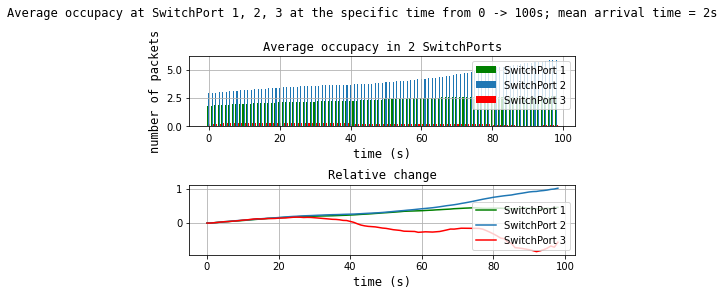

Variance of average occupacy in SwitchPort 1: 0.061533919632016355
Variance of average occupacy in SwitchPort 2: 0.727419771842892
Variance of average occupacy in SwitchPort 3: 0.004364015193529073
Variance of relative change of SwitchPort 1: 0.019066468548418904
Variance of relative change of SwitchPort 2: 0.0832475688766751
Variance of relative change of SwitchPort 3: 0.0830663388433411


In [ ]:
if __name__ == "__main__":
    main()